## Load libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.geocoders import Nominatim
from folium import Choropleth, GeoJsonTooltip, Map
from folium.plugins import MarkerCluster, HeatMap
import geopandas as gpd
%matplotlib inline

In [2]:
#Limit values to two decimal places 
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Load data into memory

In [3]:
#Here we use the Pandas library, which helps us manipulate and analyse the data.
data = pd.read_csv('dataset/911.csv')

## Which features are available on the dataset?

In [4]:
print('The features on the dataset are : ' + ", ".join(data.columns.to_list()))

The features on the dataset are : lat, lng, desc, zip, title, timeStamp, twp, addr, e


## How many rows and columns does the dataset have?

In [5]:
print('The dataset has {:,} rows and {} columns.'.format(data.shape[0], data.shape[1]))

The dataset has 663,522 rows and 9 columns.


## Now let's have a look into our data

In [6]:
data.head()

,lat,lng,desc,zip,title,timeStamp,twp,addr,e
0,40.30,-75.58,REINDEER CT & DEAD END; NEW HANOVER; Station ...,19525.00,EMS: BACK PAINS/INJURY,2015-12-10 17:10:52,NEW HANOVER,REINDEER CT & DEAD END,1
1,40.26,-75.26,BRIAR PATH & WHITEMARSH LN; HATFIELD TOWNSHIP...,19446.00,EMS: DIABETIC EMERGENCY,2015-12-10 17:29:21,HATFIELD TOWNSHIP,BRIAR PATH & WHITEMARSH LN,1
2,40.12,-75.35,HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-St...,19401.00,Fire: GAS-ODOR/LEAK,2015-12-10 14:39:21,NORRISTOWN,HAWS AVE,1
3,40.12,-75.34,AIRY ST & SWEDE ST; NORRISTOWN; Station 308A;...,19401.00,EMS: CARDIAC EMERGENCY,2015-12-10 16:47:36,NORRISTOWN,AIRY ST & SWEDE ST,1
4,40.25,-75.60,CHERRYWOOD CT & DEAD END; LOWER POTTSGROVE; S...,NaN,EMS: DIZZINESS,2015-12-10 16:56:52,LOWER POTTSGROVE,CHERRYWOOD CT & DEAD END,1


- Here, it is possible to verify that the dataset has some categorical and numerical features. We also can use the info() method from pandas to see their data types.

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 663522 entries, 0 to 663521
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   lat        663522 non-null  float64
 1   lng        663522 non-null  float64
 2   desc       663522 non-null  object 
 3   zip        583323 non-null  float64
 4   title      663522 non-null  object 
 5   timeStamp  663522 non-null  object 
 6   twp        663229 non-null  object 
 7   addr       663522 non-null  object 
 8   e          663522 non-null  int64  
dtypes: float64(3), int64(1), object(5)
memory usage: 45.6+ MB


- There are 5 features with object type and 3 are floats.

## The feature 'e' is a little bit strange. Let's take a look on how many unique values it has.

In [8]:
print('The column "e" has {} unique value: {}'.format(data.e.nunique(), ''.join(map(str, data.e.unique()))))

The column "e" has 1 unique value: 1


- The feature has only one value, therefore we can drop it, because it won't help our analysis.

In [9]:
data.drop(columns=['e'], inplace=True)

## Now, which features contain blank, null or empty values?

In [10]:
data.isnull().sum()

lat              0
lng              0
desc             0
zip          80199
title            0
timeStamp        0
twp            293
addr             0
dtype: int64

- zip feature contains 80,199 missing values. Twp has 293.

## What is the percentage of missing values when compared to the total values of the dataset?

In [11]:
print(f'{(data.isnull().sum().sum()/np.product(data.shape)):.2%}')

1.52%


## How many zip codes does the dataset have?

In [12]:
#In order to know the number of unique values from a feature, we use the nunique method from pandas:
data['zip'].nunique()

204

## What are the top 5 zip codes for 911 calls?

In [13]:
df = pd.DataFrame(data[['zip']].value_counts().nlargest(5))
df.columns = ['Count']
df = df.rename_axis(None)
display(df)

,Count
19401.00,45606
19464.00,43910
19403.00,34888
19446.00,32270
19406.00,22464


## What are the top 5 townships (twp) for 911 calls?



In [14]:
df = pd.DataFrame(data[['twp']].value_counts().head())
df.columns = ['Count']
df = df.rename_axis(None)
df

,Count
LOWER MERION,55490
ABINGTON,39947
NORRISTOWN,37633
UPPER MERION,36010
CHELTENHAM,30574


## How many unique title of emergency codes are there?



In [15]:
print('The feature "title" has {} unique value(s)'.format(data.title.nunique()))

The feature "title" has 148 unique value(s)


# Creating New Features

## Department Feature

- Let's create a new feature called 'department'. This feature will be derived from title column, which has a pattern like this: (department: tittle code)

- For instance: the first entry from title feature is (EMS: BACK PAINS/INJURY), therefore, the department would be EMS.

- We could do this in many different ways, like using the apply() method or using the split() method from pandas. Here, we're going to use apply() method.

In [16]:
data['department'] = data['title'].apply(lambda row: row.split(':')[0])

## Title_code feature

- Let's do the same thing we did above, but now for the title code.

In [17]:
data['title_code'] = data['title'].apply(lambda row: row.split(':')[1])

## Coordinate feature

- Let's create a new feature called coordinate. We'll concatenate the two columns (lat and lng)

In [18]:
data['coordinate'] = data['lat'].astype('str') + ', ' + data['lng'].astype('str')

## Year, Hour and Month and Weekday features

- Now, we're going to create some features related to the date. 
- First we need to check the timeStamp feature data type.

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 663522 entries, 0 to 663521
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   lat         663522 non-null  float64
 1   lng         663522 non-null  float64
 2   desc        663522 non-null  object 
 3   zip         583323 non-null  float64
 4   title       663522 non-null  object 
 5   timeStamp   663522 non-null  object 
 6   twp         663229 non-null  object 
 7   addr        663522 non-null  object 
 8   department  663522 non-null  object 
 9   title_code  663522 non-null  object 
 10  coordinate  663522 non-null  object 
dtypes: float64(3), object(8)
memory usage: 55.7+ MB


- It seems python isn't recognizing timeStamp feature as a date, but as an object. We need to convert it into a datetime type.
- We will use the astype() method from pandas to convert the data type.

In [20]:
data.timeStamp = data.timeStamp.astype('datetime64[ns]')

In [21]:
#Here, we see that the feature was converted successfully
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 663522 entries, 0 to 663521
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   lat         663522 non-null  float64       
 1   lng         663522 non-null  float64       
 2   desc        663522 non-null  object        
 3   zip         583323 non-null  float64       
 4   title       663522 non-null  object        
 5   timeStamp   663522 non-null  datetime64[ns]
 6   twp         663229 non-null  object        
 7   addr        663522 non-null  object        
 8   department  663522 non-null  object        
 9   title_code  663522 non-null  object        
 10  coordinate  663522 non-null  object        
dtypes: datetime64[ns](1), float64(3), object(7)
memory usage: 55.7+ MB


- Now let's create the features

In [22]:
#year feature
data['year'] = data['timeStamp'].dt.year

#hour feature 
data['hour'] = data['timeStamp'].dt.hour

#month feature
data['month'] = data['timeStamp'].dt.month

#weekday feature
data['day_of_week'] = data['timeStamp'].dt.strftime('%a')

#date feature
data['date'] = data['timeStamp'].dt.date

# Season feature

- Using apply method to return the season from each month.

In [23]:
season_dict = {'1': 'Winter',
               '2': 'Winter',
               '3': 'Spring', 
               '4': 'Spring',
               '5': 'Spring',
               '6': 'Summer',
               '7': 'Summer',
               '8': 'Summer',
               '9': 'Fall',
               '10': 'Fall',
               '11': 'Fall',
               '12': 'Winter'}

data['season'] = data['month'].apply(lambda month: season_dict[str(month)])

# Exploratory Data Analysis (EDA)

## What is the most common department for a 911 call?

In [24]:
#display the most common department (percentage of calls)
data[['department']].value_counts(normalize=True) * 100

department
EMS          50.14
Traffic      34.69
Fire         15.16
dtype: float64

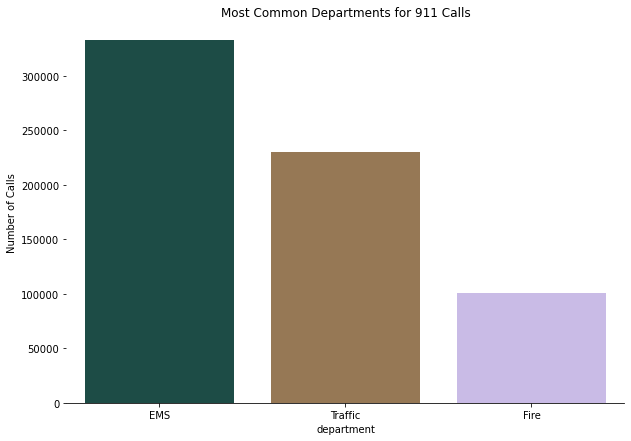

In [25]:
plt.figure(figsize=(10,7))
ax = sns.countplot(x=data['department'],
                   order = data['department'].value_counts().index,
                   palette='cubehelix')

ax.set(title='Most Common Departments for 911 Calls', ylabel='Number of Calls')
ax.grid(False)
sns.despine(bottom=False, left=True);

- Emergency Medical Services (EMS) is the most common (it holds more than half of the calls), followed by Traffic and Fire.

## What are the top 10 most common coordinate for a 911 call?

In [26]:
df = pd.DataFrame(data[['coordinate']].value_counts().head(10))
df.columns = ['Count']
df

,Count
coordinate,
"40.0972222, -75.3761952",9262
"40.1330371, -75.4084631",7285
"40.2290075, -75.3878525",5751
"40.0249667, -75.2829046",5385
"40.1723141, -75.4927278",3107
"40.1082672, -75.3062326",3096
"40.0698321, -75.3162951",2894
"40.1532684, -75.1895576",2805
"40.2890267, -75.3995896",2652


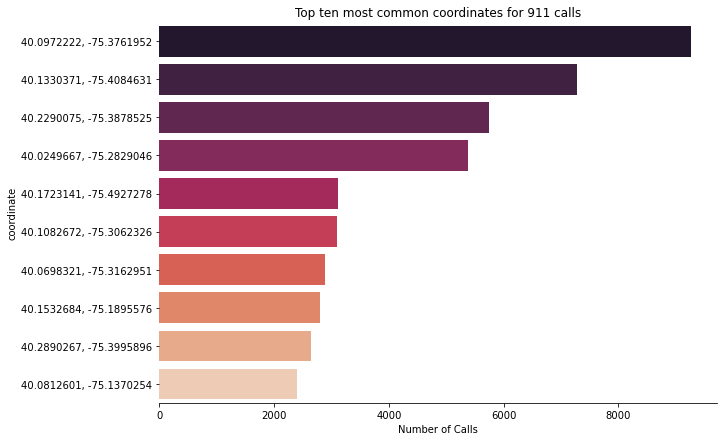

In [27]:
plt.figure(figsize=(10,7))
ax = sns.countplot(data = data,
             y = 'coordinate',
             order = data.coordinate.value_counts().iloc[:10].index,
             palette='rocket')

ax.set(title = 'Top ten most common coordinates for 911 calls', xlabel = 'Number of Calls')
sns.despine(bottom=False, left=True);

- The coordinate (40.0972222, -75.3761952) is the most common for a 911 call.

## What is the address corresponding to this set of coordinates?

In [28]:
geolocator = Nominatim(user_agent="GeoAddress")
location = geolocator.reverse(df.index[0])
print(location.address)

Upper Merion High School, Stonybrook Road, Brandywine Village, King of Prussia, Upper Merion Township, Montgomery County, Pennsylvania, 19406, United States


- The set of coordinates corresponds to an area close to a high school, in Upper Merion Township

## What are the top 10 emergency calls from all the categories?

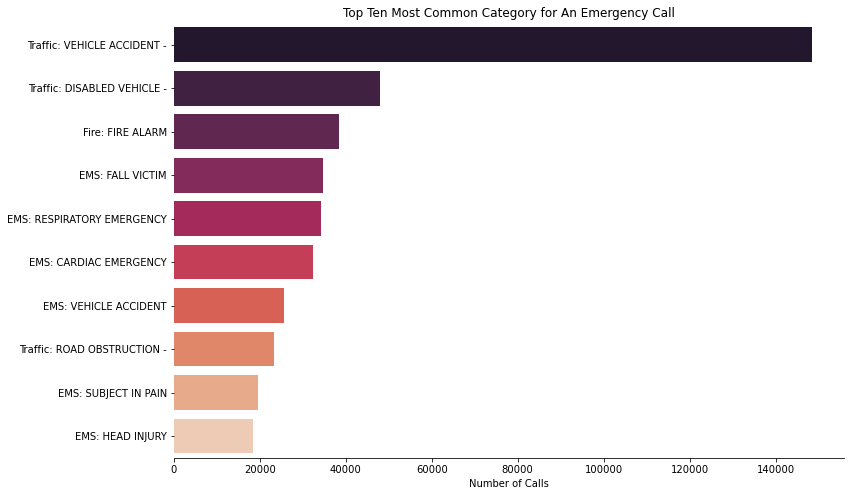

In [29]:
plt.figure(figsize=(12,8))
sns.countplot(y = 'title',
             data = data,
             order = data.title.value_counts().index[:10], palette='rocket' )\
             .set(title='Top Ten Most Common Category for An Emergency Call',
                  xlabel= 'Number of Calls', ylabel='')
sns.despine(left=True)

- Vehicle accident is, by far, the most common reason for a 911 call.

## Now, let's check the most common reasons for a 911 call where the department/reason is Traffic.

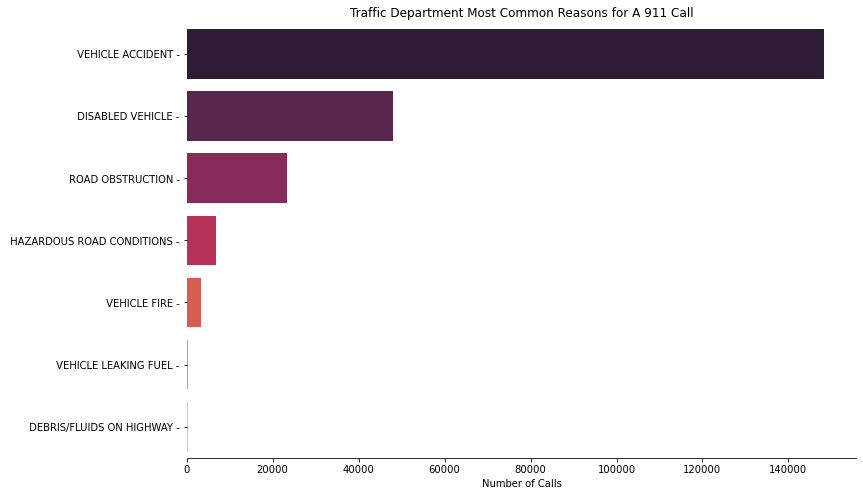

In [30]:
plt.figure(figsize=(12,8))
df_group = data[data['department'] == 'Traffic'].groupby('title_code').count().sort_values(by='desc', ascending=False).reset_index()

sns.barplot(y = 'title_code',
            x = 'desc',
            data = df_group,
            palette='rocket').set(title='Traffic Department Most Common Reasons for A 911 Call',
                                  xlabel = 'Number of Calls',
                                  ylabel = '')
sns.despine(left=True)

- The most common reason for a traffic emergency is vehicle accident.

## Let's do the same for Fire emergency, but for the top 10 reasons

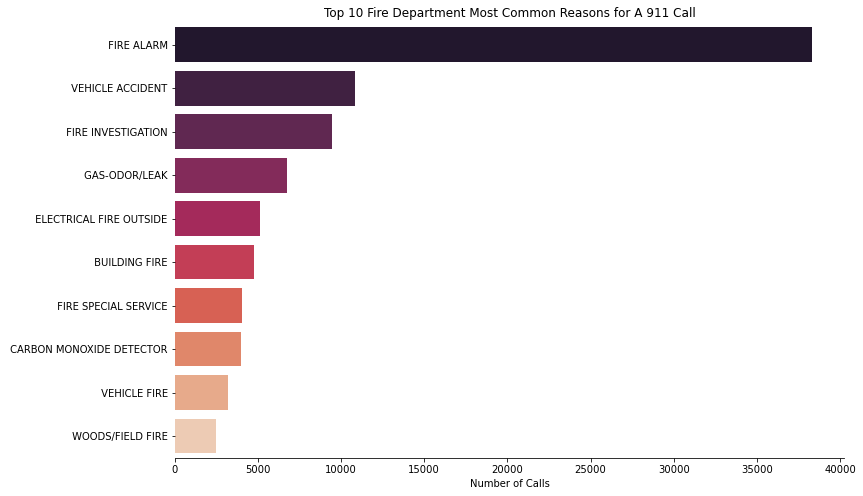

In [31]:
plt.figure(figsize=(12,8))
df_group = data[data['department'] == 'Fire'].groupby('title_code').count().sort_values(by='desc', ascending=False).reset_index()[:10]

sns.barplot(y = 'title_code',
            x = 'desc',
            data = df_group,
            palette='rocket').set(title='Top 10 Fire Department Most Common Reasons for A 911 Call',
                                  xlabel = 'Number of Calls',
                                  ylabel = '')
sns.despine(left=True)

- The most common reason for a fire emergency is fire alarm, followed by vehicle accident and fire investigation.

## And finally, let's get the top 10 reasons for a EMS call

In [32]:
df_group = data[data['department'] == 'EMS'].groupby('title_code').count().reset_index().sort_values(by='lat', ascending=False)[['title_code', 'lat']][:10]

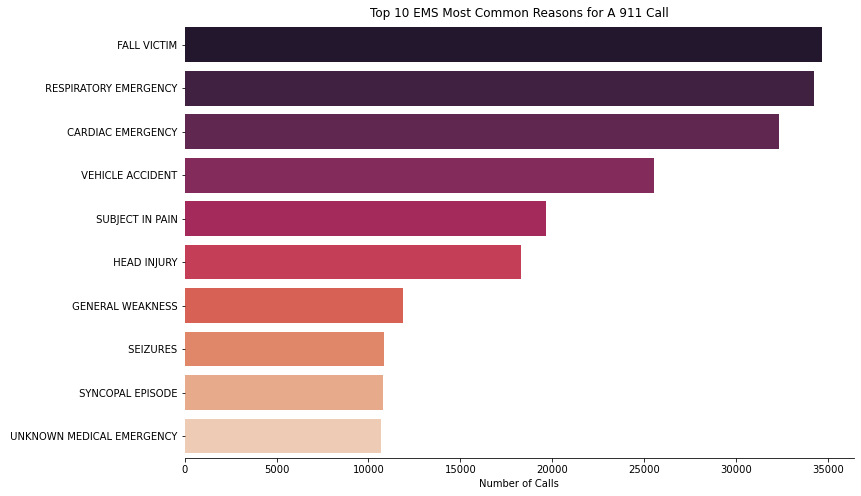

In [33]:
plt.figure(figsize=(12,8))
sns.barplot(y = 'title_code',
            x = 'lat',
            data=df_group,
            palette='rocket').set(title = 'Top 10 EMS Most Common Reasons for A 911 Call',
                                  xlabel = 'Number of Calls',
                                  ylabel = '')
sns.despine(left = True)

- The most common reason for EMS is fall victim, followed by respiratory emergency and cardiac emergency.

## Now, let's take a look at weekly and monthly calls

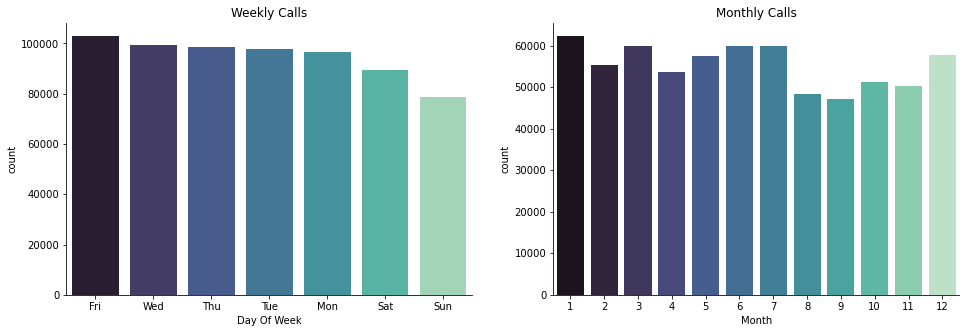

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
sns.countplot(x= 'day_of_week',
              data=data,
              order=data['day_of_week'].value_counts().index,
              palette='mako', ax=ax1).set(xlabel='Day Of Week', title='Weekly Calls')

sns.countplot(x= 'month',
              data=data,
              palette='mako', ax=ax2).set(xlabel='Month', title='Monthly Calls')

sns.despine()

- It seems like calls are more often on friday and on the first semester of the year.

## Let's recreate the monthly calls graph but now using one more information: the department

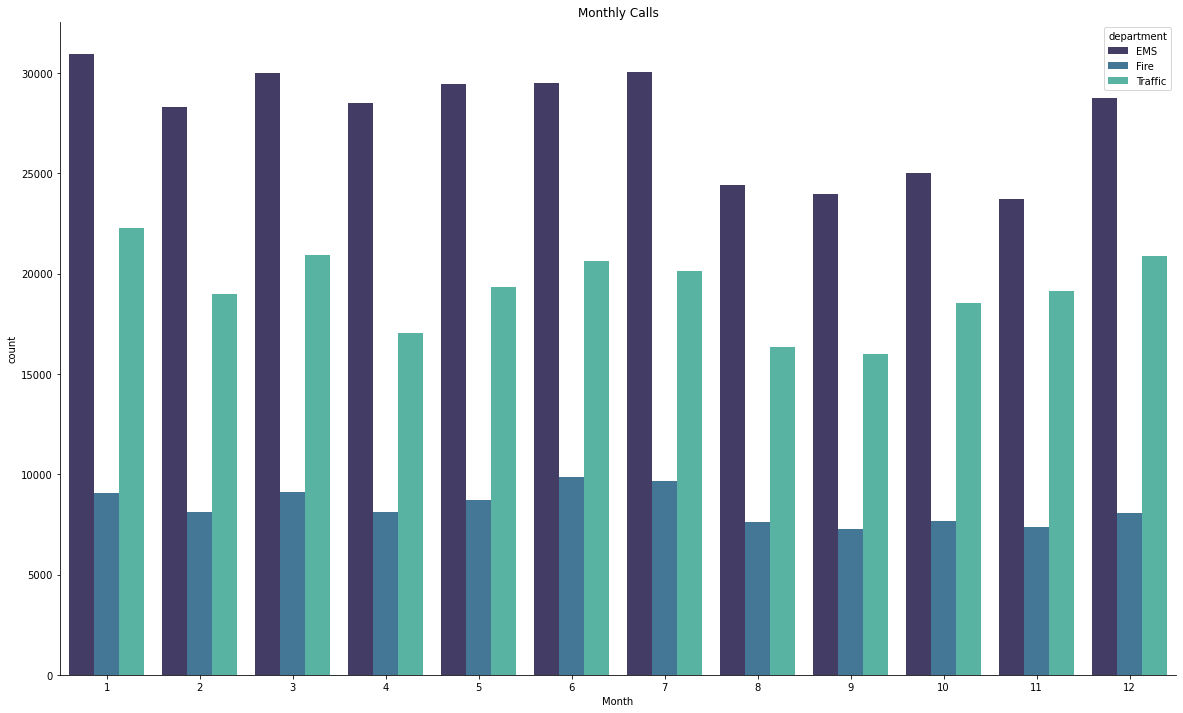

In [35]:
plt.figure(figsize=(20,12))
sns.countplot(x= 'month',
              data=data,
              palette='mako',
              hue='department').set(xlabel='Month', title='Monthly Calls')

sns.despine()

- The figure show us that the calls are more frequent on the first half of the year. Besides, EMS calls are more common, followed by Fire and Traffic.

# Now, we'll see how the calls behave on each season

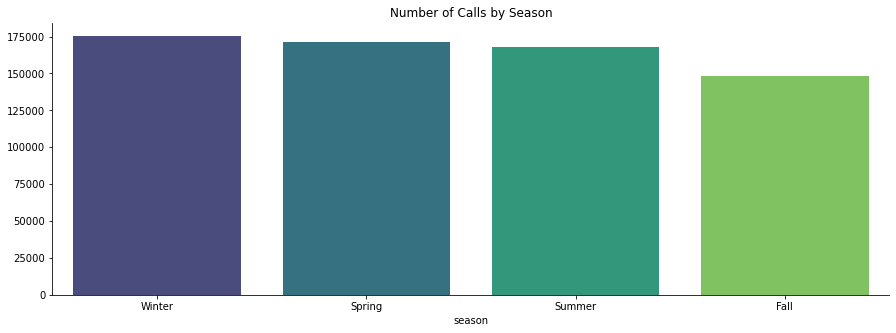

In [36]:
plt.figure(figsize=(15,5))
sns.countplot(x='season',
              data=data,
              order = data['season'].value_counts().index,
              palette='viridis').set(title= 'Number of Calls by Season', ylabel='')

sns.despine()

- There's no much variation on number of calls in winter, spring and summer.

## Now, we'll create a dashboard which will show us how the number of calls by day for each department behaves

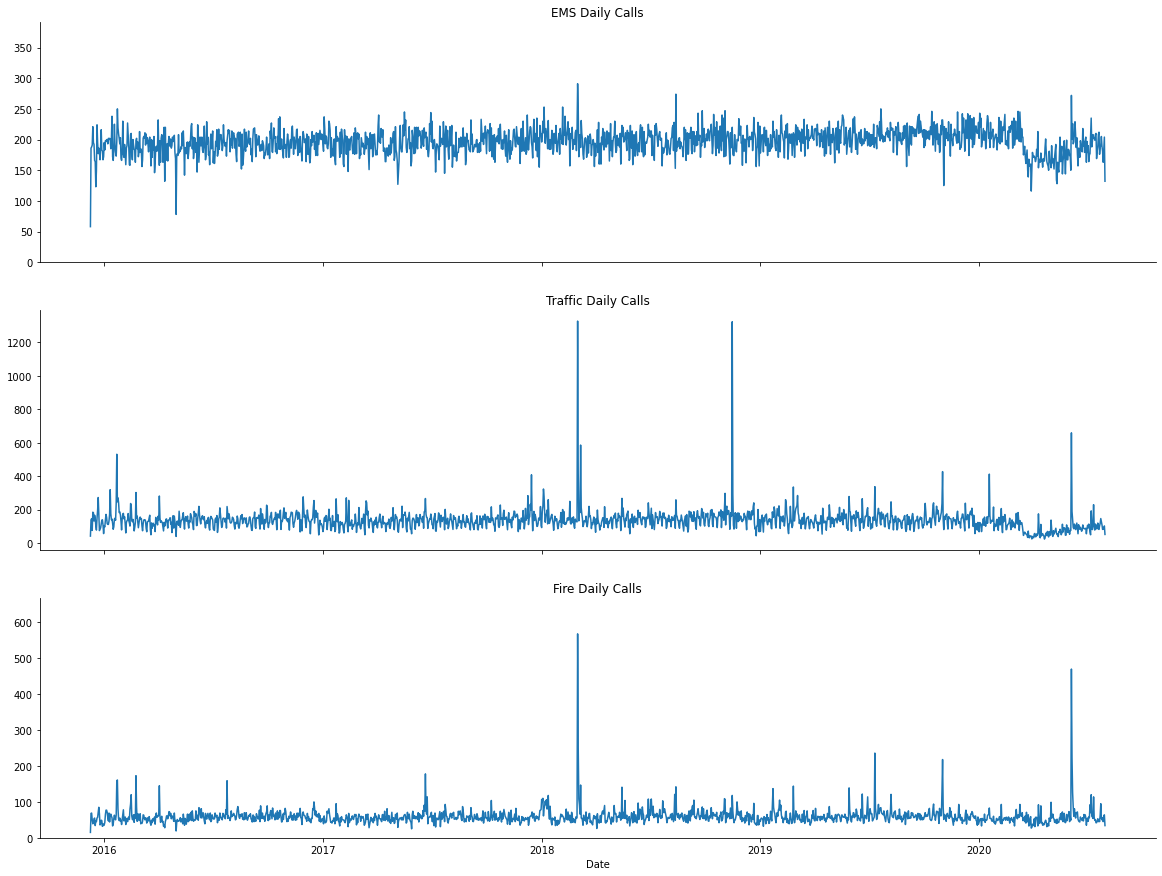

In [37]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(20,15))

#first fig
group1 = data[data['department'] == 'EMS'].groupby('date').count()['department'].reset_index()

sns.lineplot(x='date', y='department', data=group1, ax=ax1).set(title= 'EMS Daily Calls',
                                                                xlabel='', ylabel='', 
                                                                ylim=(0, group1['department'].max() + 100),
                                                                xticklabels='')
plt.ylim((0, 100))

#second fig
group2 = data[data['department'] == 'Traffic'].groupby('date').count()['department'].reset_index()

sns.lineplot(x='date', y='department', data=group2, ax=ax2).set(title= 'Traffic Daily Calls',
                                                                xlabel='', ylabel='',
                                                                xticklabels='')

#third fig
group3 = data[data['department'] == 'Fire'].groupby('date').count()['department'].reset_index()

sns.lineplot(x='date', y='department', data=group3, ax=ax3).set(title= 'Fire Daily Calls',
                                                                xlabel='Date', 
                                                                ylabel='',
                                                                ylim=(0, group3['department'].max()+100))
sns.despine()


## Let's check the most common day of week and hour for 911 calls.

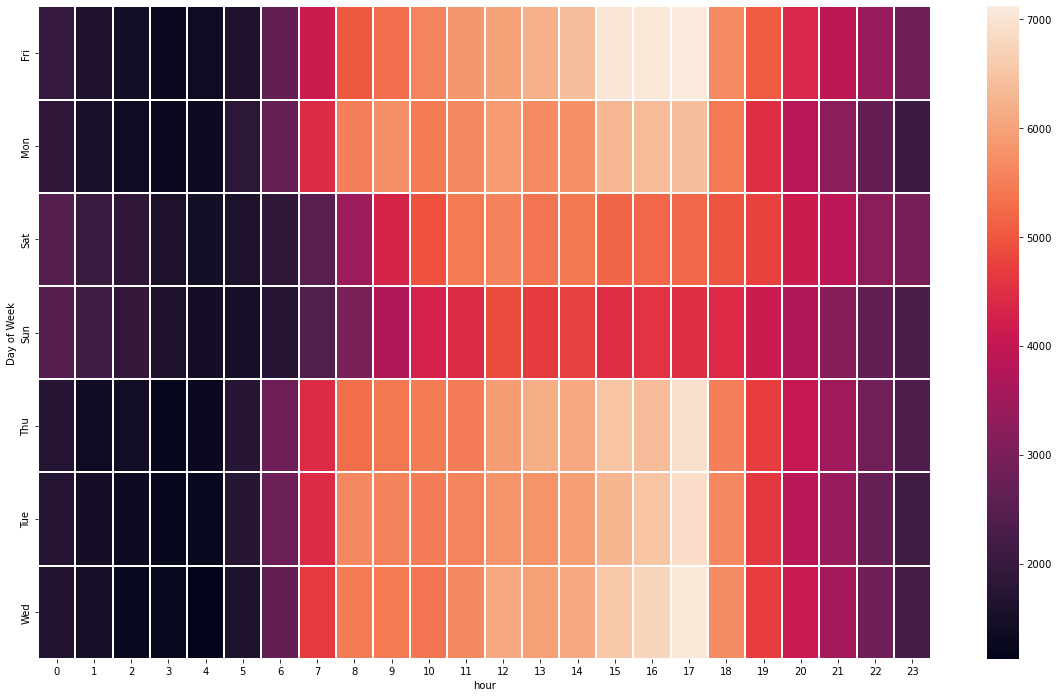

In [38]:
plt.figure(figsize=(20,12))

#we'll group the dataframe by day of week and hour and then use unstack pandas method to create a new header
sns.heatmap(data = data.groupby(by=['day_of_week', 'hour']).count()['department'].unstack(), linewidths=0.004)

plt.ylabel('Day of Week');

- Friday and Wednesday are the most common days for a 911 call and there are more calls during 15:00 and 17:00h.
- 17:00h seems to be the peak hour for 911 calls
- Sunday is the day with fewer calls

## Which region has the most 911 calls? Let's check it through a map.

In [39]:
#loading geojson file with geopandas
geofile = gpd.read_file('dataset/Montgomery_County_Municipal_Boundaries.geojson')

In [40]:
#checking for townships written in a diferent way  on each dataframe
set(geofile['Name'].str.lower()) - set(data['twp'].str.lower())

{'hatfield twp'}

- Geofile dataframe contains a value called Hatfield twp, but it has a different name in our dataset.
- In the dataset, hatfield twp is spelled as Harfield Township, so let's replace the name on geofile data.

In [41]:
#first letters capitalized
data['twp'] = data['twp'].str.title()

#replace township name
geofile['Name'] = geofile['Name'].replace('Hatfield Twp', 'Hatfield Township')

In [42]:
#creating new dataframe grouped by township
df = data['twp'].value_counts().reset_index()
df.columns = ['Township', 'Number of Calls']

In [43]:
#merging geofile and the new dataframe
merged_df = pd.merge(geofile, df, left_on='Name', right_on='Township' , how='inner')

In [44]:
# Creating a basemap
fig = Map(location=[40.18, -75.36], zoom_start=10)

#creating choropleth map
choropleth = Choropleth(geo_data=merged_df,
                               data=merged_df,
                               columns=['Township', 'Number of Calls'],
                               key_on='feature.properties.Township',
                               fill_color="YlGn",
                               fill_opacity = 0.7,
                               line_opacity=0.4,
                               highlight=True,
                               name='Montgomery County',
                               legend_name='Number of Calls').add_to(fig)


#adding tooltip to the map
GeoJsonTooltip(['Township','Number of Calls']).add_to(choropleth.geojson)

# Plotting the map
fig

- With the help of the map we can see that Lower Merion has the most 911 calls (55490), followed by Abington (39947) and Norristown (37633).

## Now, let's plot a heatmap from Lower Merion region to see how the calls are distributed geographically

In [45]:
# Creating a basemap centered in the Lower Merion Township region
basemap = Map(location=[40.18, -75.36], zoom_start=10)

# Creating lists with lat and lng data points
lat = data[data['twp'] == 'Lower Merion'].lat.tolist()
lng = data[data['twp'] == 'Lower Merion'].lng.tolist()

# Adding the heatmap layer
HeatMap(list(zip(lat, lng)),radius=15,).add_to(basemap)

# Plotting the map
display(basemap)

## Conclusions

- Lower Merion has the most 911 calls (55490), followed by Abington (39947) and Norristown (37633).

- EMS (Emergency Medical Services) department got the most 911 calls. It got more than half of the total calls (50.14%). 

- The coordinate (40.0972222, -75.3761952) is the most common for a 911 call; and it corresponds to an area close to a high school, in Upper Merion Township.

- Vehicle accident is the most common reason for a 911 call.

- The most common reason for a fire emergency is fire alarm.

- The most common reason for EMS is fall victim, followed by respiratory emergency and cardiac emergency.

- Friday and Wednesday are the most common days for a 911 call and there are more calls during 15:00h and 17:00h.